In [1]:
import sys
import os
import numpy as np
import torch
import pandas as pd
import csv
from scipy.stats import binom
from sklearn.metrics import roc_auc_score
import torch.nn as nn

In [2]:
# custom imports
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../..")))

from src.utils import load_config
import src.graphs_generation as graphs_gen

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

c:\Users\danie\Desktop\Virtual Envs\ML\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Model definition

## Common functions

Functions adapted from:
`\HUPLACLIP-NNs\scripts\visualizations\degree_distribution.ipynb`

In [3]:
def p_correction(p_nodes, graph_size, clique_size):
    '''Returns the value of the corrected p-value in the graph with clique ("p_reduce" case) '''
    p_corrected = (
        p_nodes * graph_size * (graph_size - 1)
        - clique_size * (clique_size - 1)
    ) / ((graph_size - clique_size) * (graph_size + clique_size - 1))
    return p_corrected

# P(d|C=0)
def p_noclique(degree_arr, graph_size):
    ''' 
    For an array of degree values (degree_arr: ndarray of shape [N_graphs, 1, graph_size]), returns the probability that (in a graph WITHOUT the clique) a node has exactly that degree.    
    Returns: ndarray of probabilities, same shape as degree_arr
    '''
    return binom.pmf(degree_arr, 
                     graph_size-1, 
                     0.5    # "p_reduce" correction only acts on graph with clique
                     )

def expected_count_noclique(degree_arr, graph_size):
    '''
    Uses p_noclique to obtain the number of nodes that (in a graph WITHOUT the clique) are expected to have exactly that degree.
    '''
    # expected count = graph_size * probability_per_node
    return graph_size * p_noclique(degree_arr, graph_size)

# P(d|C=1)
def p_ingroup(degree_arr, graph_size, clique_size, p_corrected):
    ''' 
    For an array of degree values (degree_arr: ndarray of shape [N_graphs, 1, graph_size]), returns the probability that (in a graph WITH the clique) a node INSIDE the clique has exactly that degree.    
    Returns: ndarray of probabilities, same shape as degree_arr
    '''
    return binom.pmf(degree_arr - (clique_size-1),  # number of non-clique connections
                     graph_size - clique_size,      # number of possible non-clique nodes
                     p_corrected
                     )

def p_outgroup(degree_arr, graph_size, clique_size, p_corrected):
    ''' 
    For an array of degree values (degree_arr: ndarray of shape [N_graphs, 1, graph_size]), returns the probability that (in a graph WITH the clique) a node OUTSIDE the clique has exactly that degree.    
    Returns: ndarray of probabilities, same shape as degree_arr
    '''
    return binom.pmf(degree_arr, 
                     graph_size-1, 
                     p_corrected
                     )

def expected_count_clique(degree_arr, graph_size, clique_size, p_corrected):
    '''Combines p_outgroup and p_ingroup (single mixture) to obtain the number of nodes that (in a graph WITH the clique) are expected to have exactly that degree'''
    prob = clique_size/graph_size * p_ingroup(degree_arr, graph_size, clique_size, p_corrected) + (1-clique_size/graph_size) * p_outgroup(degree_arr, graph_size, clique_size, p_corrected)    
    # expected count = graph_size * probability_per_node
    prob = graph_size * prob
    return prob

## Architecture diagrams

"Ideal MLP" designed starting from this initial sketch (11/11/2025):

![Alt text](../../scripts/Ideal-MLP_performance/whiteboard_images/Ideal-MLP-sketch.jpg)

More complete diagram (17/11/2025):

![Alt text](../../scripts/Ideal-MLP_performance/whiteboard_images/Zoom-Meeting_2025-11-17_Ideal-MLP_architecture.png)

## "Function" implementation

Here we design the Ideal MLP as an input/output function, to check that the resolution strategy works correctly. It includes both the "k-known" and "k-not-known" cases.

In [41]:
class Ideal_MLP(nn.Module):
    
    # NOTE possible improvements:
    # - handle with actual bins (now n_bins = N)
    # - standardization before comparing clique/no clique
    # - "left" and "right" blocks can be simplified?
    
    def __init__(self, graph_size:int, max_clique_prop:float = 0.7, k_known:bool = False):
        super().__init__()
        self.graph_size = graph_size
        self.k_known = k_known
        
        # Precomputing variables:
        print("Precomputing variables...")
        # - array of bin edges: 
        self.tau = torch.arange(0, self.graph_size+1) #NOTE: possible improvement is extending this to actual bins spanning more than 1 single value
        #print("Tau values: ", self.tau)
        # - array of clique size values:
        max_K = int(max_clique_prop * self.graph_size)
        stat_lim = round(2 * np.log2(self.graph_size))
        self.clique_size_values = torch.arange(1, max_K + 1)  # from statistical limit to max_K
        print("Clique size values: ", self.clique_size_values)
        # - compute expected histograms and store as torch.float32 tensors
        # -- no clique
        self.expected_hist_no_clique = torch.tensor(
            expected_count_noclique(self.tau, self.graph_size), dtype=torch.float32
        )  # shape: (len_tau, 1) NOTE: these should sum to N given that they are expected counts
        expected_hist_clique = []
        # -- clique (calculating expected histogram for all possible clique size values)
        for K in self.clique_size_values:
            p_corrected = p_correction(0.5, self.graph_size, K)
            expected_hist_K = expected_count_clique(self.tau, self.graph_size, K, p_corrected)  # shape: (len_tau, 1) NOTE: these should sum to N given that they are expected counts
            expected_hist_clique.append(torch.tensor(expected_hist_K, dtype=torch.float32))
        self.expected_hist_clique = torch.stack(expected_hist_clique, dim=1)  # shape: (len_tau, len_clique_size_values)        
        print("Completed precomputing variables...")
        
    # Processing blocks:
    def forward(self, adj_matrices: torch.Tensor, clique_size: int = None):
        '''
        Input: adj_matrices of shape [batch_size, 1, N, N]
        Optional input: clique_size (int) - if provided, use that single clique size's expected histogram
        Output: tensor of shape [batch_size] (probability of "clique")
        '''
        if(adj_matrices.shape[2] != self.graph_size):
            raise ValueError(f"Input graphs have size {adj_matrices.shape[2]}, but model was initialized for size {self.graph_size}")
                    
        # if model expects a known K, require it be passed
        if self.k_known and clique_size is None:
            raise ValueError("Model was initialized with k_known=True but no clique_size was provided to forward().")

        # compute degree of each node (sum over rows)
        degrees = torch.sum(adj_matrices, dim=2)  # shape: (batch_size, 1, N)
        degrees = degrees.squeeze(1)  # shape: (batch_size, N)
        
        # Vectorized: degrees shape (batch_size, N)
        batch_size, N = degrees.shape
        len_tau = len(self.tau)

        # cast tau to same dtype/device and reshape for broadcasting:
        tau_val = self.tau.to(dtype=degrees.dtype, device=degrees.device).view(1, len_tau, 1)  # shape: (1, len_tau, 1)
        deg_batched = degrees.view(batch_size, 1, N)  # shape: (batch_size, 1, N)

        # "left" block (broadcasts to (batch_size, len_tau, N))
        x_left = torch.relu(deg_batched - (tau_val - 2.0))
        x_left = torch.relu(2.0 - x_left)
        left = x_left - torch.relu(x_left - 1.0)

        # "right" block (broadcasts to (batch_size, len_tau, N))
        x_right = torch.relu(deg_batched - (tau_val - 1.0))
        x_right = torch.relu(2.0 - x_right)
        right = x_right - torch.relu(x_right - 1.0)

        # indicator matrix per graph: (batch_size, len_tau, N)
        degree_indicator_matrices = (right - left)  # float tensor with 0/1 values

        # summing over nodes to get raw histograms:
        raw_histograms = degree_indicator_matrices.sum(dim=2)  # shape (batch_size, len_tau)
        
        # computing differences with expected histograms:
        # - no clique case:
        expected_no_clique = self.expected_hist_no_clique.to(dtype=degrees.dtype, device=degrees.device).view(1, len_tau)  # shape: (1, len_tau)
        diff_no_clique = torch.abs(raw_histograms - expected_no_clique)  # shape: (batch_size, len_tau)
        mean_diff_no_clique = torch.mean(diff_no_clique, dim=1)  # shape: (batch_size,)  

        # - clique case:
        # prepare expected_clique depending on provided clique_size
        if clique_size is not None:
            k_val = int(clique_size)
            k_list = [int(x) for x in self.clique_size_values.tolist()]
            if k_val not in k_list:
                raise ValueError(f"Provided clique_size={k_val} is not in precomputed clique_size_values: {k_list}")
            idx = k_list.index(k_val)
            # pick single-column expected histogram and shape to (1, len_tau, 1)
            expected_clique = self.expected_hist_clique[:, idx].to(dtype=degrees.dtype, device=degrees.device).unsqueeze(0).unsqueeze(2)
        else:
            # use all precomputed Ks and average over them later; shape -> (1, len_tau, num_K)
            expected_clique = self.expected_hist_clique.to(dtype=degrees.dtype, device=degrees.device).unsqueeze(0)

        # compute differences per K (or single K)
        raw_expanded = raw_histograms.unsqueeze(2)  # (batch_size, len_tau, 1)
        diff_clique_per_tau = torch.abs(raw_expanded - expected_clique)  # (batch_size, len_tau, num_K)
        diff_clique_per_K = torch.mean(diff_clique_per_tau, dim=1)  # (batch_size, num_K)
        mean_diff_clique = torch.mean(diff_clique_per_K, dim=1)  # (batch_size,)

        # final decision: smaller difference -> more likely that class
        logits = mean_diff_no_clique - mean_diff_clique  # positive -> more likely clique
        probs = torch.sigmoid(logits)  # probability of "clique" per graph

        # # Visualization of empirical histogram if first graph of the batch and expected counts       
        # import matplotlib.pyplot as plt
        # # convert tensors to numpy arrays
        # raw_vec = raw_histograms[0].detach().cpu().numpy()
        # expected_no_np = expected_no_clique.squeeze(0).detach().cpu().numpy()  # (len_tau,)
        # mean_no = expected_no_np.astype(float)
        # std_no = np.sqrt(self.graph_size * (mean_no / N) * (1.0 - mean_no / N))
        # plt.figure(figsize=(8,3))
        # plt.plot(raw_vec, label="empirical (first graph)", color="k")
        # plt.plot(mean_no, label="expected (no-clique)", color="C0")
        # plt.fill_between(np.arange(mean_no.shape[0]), mean_no - std_no, mean_no + std_no, color="C0", alpha=0.4)
        # # clique case: handle k_known or multiple Ks (pick best K for first graph)
        # exp_clq = expected_clique  # shape: (1, len_tau, num_K)
        # num_K = exp_clq.shape[2]
        # if clique_size is not None:
        #     k_list = [int(x) for x in self.clique_size_values.tolist()]
        #     clique_idx = k_list.index(int(clique_size))
        #     expected_clique_np = exp_clq[0, :, 0].detach().cpu().numpy()            
        # else:
        #     clique_idx = int(torch.argmin(diff_clique_per_K[0]).item())
        #     expected_clique_np = exp_clq[0, :, clique_idx].detach().cpu().numpy()
        # mean_clique = expected_clique_np.astype(float)
        # std_clique = np.sqrt(self.graph_size * (mean_clique / N) * (1.0 - mean_clique / N))
        # plt.plot(mean_clique, label=f"expected (clique K={self.clique_size_values[clique_idx]}{', best K' if not self.k_known else ''})", color="C1")
        # plt.fill_between(np.arange(mean_clique.shape[0]), mean_clique - std_clique, mean_clique + std_clique, color="C1", alpha=0.4)
        # plt.title("K known" if self.k_known else "K not known")
        # plt.xlim(0, len(self.tau))
        # plt.legend(fontsize=9)
        # plt.tight_layout()
        # plt.xlim(self.graph_size*0.3, self.graph_size*0.7)
        # plt.show()

        return probs


Clique size of:  120  in a graph of size:  600


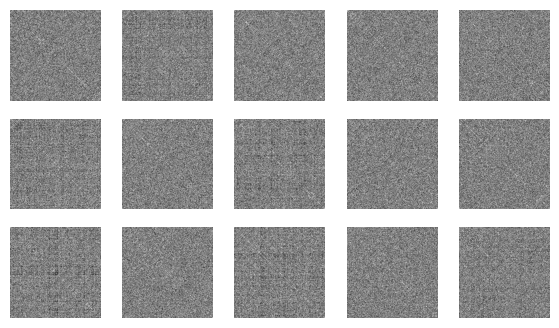

K-known case: 
Precomputing variables...
Clique size values:  tensor([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,  14,
         15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  28,
         29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,  42,
         43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,  56,
         57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,  70,
         71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,  84,
         85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,  98,
         99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112,
        113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126,
        127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140,
        141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154,
        155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
  

C:\Users\danie\AppData\Local\Temp\ipykernel_13568\1984253071.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  expected_hist_clique.append(torch.tensor(expected_hist_K, dtype=torch.float32))


Completed precomputing variables...


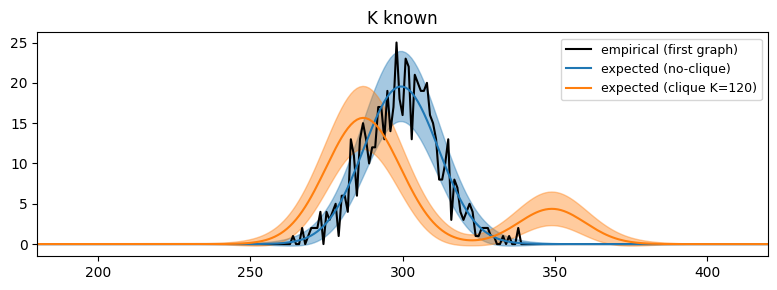

||Soft outputs: tensor([0.3403, 0.6324, 0.3554, 0.3341, 0.3410, 0.6445, 0.3617, 0.6274, 0.3502,
        0.3322, 0.6565, 0.3545, 0.6446, 0.3475, 0.6459])
||Hard outputs:  [0 1 0 0 0 1 0 1 0 0 1 0 1 0 1]
||Labels:  [0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0]
||Fraction of correct responses:
1.0
K-not-known case: 
Precomputing variables...
Clique size values:  tensor([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,  14,
         15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  28,
         29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,  42,
         43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,  56,
         57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,  70,
         71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,  84,
         85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,  98,
         99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109,

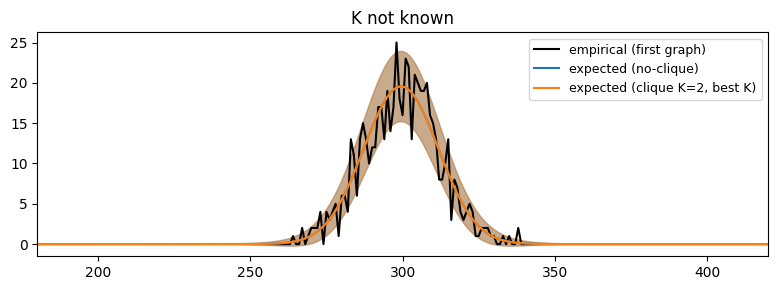

||Soft outputs: tensor([0.2334, 0.3777, 0.2398, 0.2312, 0.2390, 0.3958, 0.2420, 0.3794, 0.2372,
        0.2326, 0.3965, 0.2394, 0.3871, 0.2383, 0.3845])
||Hard outputs:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
||Labels:  [0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0]
||Fraction of correct responses:
0.6


In [40]:
import matplotlib.pyplot as plt

# test of model on task instance
N_value = 600   #CHANGE THIS
clique_size_fraction = 0.2 # CHANGE THIS
print("Clique size of: ", int(clique_size_fraction*N_value), " in a graph of size: ", N_value)
# visualizing input for 15 graphs, "p_reduce"
graphs_with_clique = graphs_gen.generate_batch(15, N_value, np.repeat([int(clique_size_fraction*N_value)],15), "p_reduce", False)
# Show 15 graphs
fig, axes = plt.subplots(3, 5, figsize=(7, 4))
for i in range(15):
    row = i // 5
    col = i % 5
    axes[row, col].imshow(np.squeeze(graphs_with_clique[0][i]), cmap='gray_r')
    axes[row, col].axis('off')
plt.show()
# testing ideal MLP on this graph:
print("K-known case: ")
ideal_MLP = Ideal_MLP(N_value, k_known = True)
soft_output = ideal_MLP(graphs_with_clique[0], int(clique_size_fraction*N_value))
hard_output = (soft_output >= 0.5).long().cpu().numpy()  # threshold at 0.5
print("||Soft outputs:", soft_output)
print("||Hard outputs: ", hard_output)
print("||Labels: ", graphs_with_clique[1])
print("||Fraction of correct responses:")
print(np.sum(hard_output == graphs_with_clique[1]) / 15)

print("K-not-known case: ")
ideal_MLP = Ideal_MLP(N_value)
soft_output = ideal_MLP(graphs_with_clique[0])
hard_output = (soft_output >= 0.5).long().cpu().numpy()  # threshold at 0.5
print("||Soft outputs:", soft_output)
print("||Hard outputs: ", hard_output)
print("||Labels: ", graphs_with_clique[1])
print("||Fraction of correct responses:")
print(np.sum(hard_output == graphs_with_clique[1]) / 15)

## Test

In [42]:
# read configuration file:
config = load_config(
    os.path.join("Ideal-MLP_test_config.yml")
)  # CHANGE THIS TO PERFORM DIFFERENT EXPERIMENTS

# looping over the models to be tested:
for model_name in config["models"]:
    
    # looping over the different graph sizes in the experiment:
    for graph_size in config["graph_size_values"]:
        
        if("not" not in model_name):
            ideal_MLP = Ideal_MLP(graph_size, k_known=True).to(device)
        else:
            ideal_MLP = Ideal_MLP(graph_size).to(device)

        # Create empty dictionaries for storing testing results:
        fraction_correct_results = {}  # Fraction correct for each clique size
        metrics_results_list = []

        # Calculate max clique size for testing (proportion of graph size):
        max_clique_size_proportion_test = config["testing_parameters"]["max_clique_size_proportion_test"]
        max_clique_size = int(
            max_clique_size_proportion_test * graph_size
        )

        # Calculate array of clique sizes for all test curriculum
        # NOTE: if max clique size is smaller than the the number of test levels, use max clique size as the number of test levels
        clique_sizes = np.linspace(
            max_clique_size,
            1,
            num=min(max_clique_size, config["testing_parameters"]["clique_testing_levels"]),
        ).astype(int)
        
        # Metrics initialization
        TP, FP, TN, FN = 0, 0, 0, 0  
        y_scores = []
        y_true = []    

        # Loop for decreasing clique sizes
        for current_clique_size in clique_sizes:

            # Initialize fraction correct list, updated at each test iteration
            fraction_correct_list = []

            # Loop for testing iterations:
            for test_iter in range(config["testing_parameters"]["test_iterations"]):

                # Generate clique size value of each graph in the current batch
                clique_size_array_test = graphs_gen.generate_batch_clique_sizes(
                    np.array([current_clique_size]),
                    config["testing_parameters"]["num_test"],
                )

                # Generate validation graphs
                test = graphs_gen.generate_batch(
                    config["testing_parameters"]["num_test"],
                    graph_size,
                    clique_size_array_test,
                    config["p_correction_type"],
                    False,
                )
                
                # Perform prediction on test data
                if("not" not in model_name):
                    soft_output = ideal_MLP(test[0], current_clique_size).squeeze()
                else:
                    soft_output = ideal_MLP(test[0]).squeeze()
                hard_output = (soft_output >= 0.5).int().cpu().numpy()  # converting to hard output (0/1)
                # print(hard_output.shape, test_labels.shape)   # DEBUGGING

                # Update global metrics for AUC-ROC
                y_scores.extend(soft_output.cpu().tolist())
                labels = test[1]
                y_true.extend(list(labels))
                
                # transforming hard_output and test_labels to torch tensors:
                hard_output = torch.tensor(hard_output, dtype=torch.float32)
                test_labels = torch.tensor(test[1], dtype=torch.float32)
                
                # # DEBUGGING:
                # print("Soft outputs: ", soft_output)
                # print("Hard outputs: ", hard_output)
                # print("Test labels: ", test_labels)
                
                # Compute metrics
                TP += ((hard_output == 1) & (test_labels == 1)).sum().item()
                FP += ((hard_output == 1) & (test_labels == 0)).sum().item()
                TN += ((hard_output == 0) & (test_labels == 0)).sum().item()
                FN += ((hard_output == 0) & (test_labels == 1)).sum().item()

                # updating fraction correct list with the accuracy of the current test iteration:
                fraction_correct_list.append(
                    (hard_output == test_labels).sum().item()
                    / (1.0 * config["testing_parameters"]["num_test"])
                )
                
                # delete unused variables
                del test, hard_output, test_labels, clique_size_array_test, soft_output
                torch.cuda.empty_cache()

            # Updating dictionary after all test iterations for current clique size have been completed:
            fraction_correct_results[current_clique_size] = round(
                sum(fraction_correct_list) / len(fraction_correct_list), 2
            )

            # Printing the size of the clique just tested and the corresponding test accuracy:
            print(
                f"||| Completed testing for clique = {current_clique_size}. "
                f"Average fraction correct = {fraction_correct_results[current_clique_size]}"
            )
            print("|||===========================================================")

        # - notify completion of testing:
        label = 'K not known' if 'not' in model_name else 'K known'
        print(f"| Finished testing Ideal MLP ({label}) at N = {graph_size}.")        

        # Computing metrics:
        precision = TP / (TP + FP + 1e-10)
        recall = TP / (TP + FN + 1e-10)
        F1 = 2 * (precision * recall) / (precision + recall + 1e-10)
        AUC_ROC = roc_auc_score(y_true, y_scores)
        num_params = sum(
            p.numel() for p in ideal_MLP.parameters()
        )  # storing total number of parameters
        metrics_results = {
            "TP": TP,
            "FP": FP,
            "TN": TN,
            "FN": FN,
            "precision": precision,
            "recall": recall,
            "F1": F1,
            "AUC_ROC": AUC_ROC,
            "total_params": num_params,
        }

        # Saving accuracy results in .csv file:
        model_label = 'k-not-known' if "not" in model_name else 'k-known'
        # - defining file name and path:
        file_path = os.path.join(
            os.getcwd(), "results", f"Ideal-MLP_{model_label}_N{graph_size}_fraction_correct.csv"
        )
        # - saving the dictionary as a .csv file:
        with open(file_path, "w") as file:
            writer = csv.writer(file)
            writer.writerow(["clique size", "fraction correct"])  # Add column labels
            for key, value in fraction_correct_results.items():
                writer.writerow([key, value])
        # Saving metrics results in .csv file:
        # - defining file name and path:
        file_path = os.path.join(
            os.getcwd(), "results", f"Ideal-MLP_{model_label}_N{graph_size}_metrics.csv"
        )
        # - saving the dictionary as a .csv file:
        pd.DataFrame([metrics_results]).to_csv(file_path, index=False)

        print(f"- Ideal MLP Results saved successfully for N = {graph_size}.")

Configuration file loaded successfully.
Precomputing variables...
Clique size values:  tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
        19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36,
        37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54,
        55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70])
Completed precomputing variables...
||| Completed testing for clique = 70. Average fraction correct = 1.0
|||===========================================================
||| Completed testing for clique = 69. Average fraction correct = 1.0
|||===========================================================


C:\Users\danie\AppData\Local\Temp\ipykernel_13568\2652851861.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  expected_hist_clique.append(torch.tensor(expected_hist_K, dtype=torch.float32))


||| Completed testing for clique = 68. Average fraction correct = 1.0
|||===========================================================
||| Completed testing for clique = 67. Average fraction correct = 1.0
|||===========================================================
||| Completed testing for clique = 66. Average fraction correct = 1.0
|||===========================================================
||| Completed testing for clique = 65. Average fraction correct = 1.0
|||===========================================================
||| Completed testing for clique = 64. Average fraction correct = 1.0
|||===========================================================
||| Completed testing for clique = 63. Average fraction correct = 1.0
|||===========================================================
||| Completed testing for clique = 62. Average fraction correct = 1.0
|||===========================================================
||| Completed testing for clique = 61. Average fraction correct = 1.0

C:\Users\danie\AppData\Local\Temp\ipykernel_13568\2652851861.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  expected_hist_clique.append(torch.tensor(expected_hist_K, dtype=torch.float32))


Completed precomputing variables...
||| Completed testing for clique = 105. Average fraction correct = 1.0
|||===========================================================
||| Completed testing for clique = 103. Average fraction correct = 1.0
|||===========================================================
||| Completed testing for clique = 102. Average fraction correct = 1.0
|||===========================================================
||| Completed testing for clique = 101. Average fraction correct = 1.0
|||===========================================================
||| Completed testing for clique = 100. Average fraction correct = 1.0
|||===========================================================
||| Completed testing for clique = 99. Average fraction correct = 1.0
|||===========================================================
||| Completed testing for clique = 98. Average fraction correct = 1.0
|||===========================================================
||| Completed testing for cl

C:\Users\danie\AppData\Local\Temp\ipykernel_13568\2652851861.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  expected_hist_clique.append(torch.tensor(expected_hist_K, dtype=torch.float32))


||| Completed testing for clique = 140. Average fraction correct = 1.0
|||===========================================================
||| Completed testing for clique = 138. Average fraction correct = 1.0
|||===========================================================
||| Completed testing for clique = 137. Average fraction correct = 1.0
|||===========================================================
||| Completed testing for clique = 135. Average fraction correct = 1.0
|||===========================================================
||| Completed testing for clique = 134. Average fraction correct = 1.0
|||===========================================================
||| Completed testing for clique = 132. Average fraction correct = 1.0
|||===========================================================
||| Completed testing for clique = 131. Average fraction correct = 1.0
|||===========================================================
||| Completed testing for clique = 130. Average fraction corre

C:\Users\danie\AppData\Local\Temp\ipykernel_13568\2652851861.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  expected_hist_clique.append(torch.tensor(expected_hist_K, dtype=torch.float32))


Completed precomputing variables...
||| Completed testing for clique = 210. Average fraction correct = 1.0
|||===========================================================
||| Completed testing for clique = 207. Average fraction correct = 1.0
|||===========================================================
||| Completed testing for clique = 205. Average fraction correct = 1.0
|||===========================================================
||| Completed testing for clique = 203. Average fraction correct = 1.0
|||===========================================================
||| Completed testing for clique = 201. Average fraction correct = 1.0
|||===========================================================
||| Completed testing for clique = 199. Average fraction correct = 1.0
|||===========================================================
||| Completed testing for clique = 197. Average fraction correct = 1.0
|||===========================================================
||| Completed testing for 

C:\Users\danie\AppData\Local\Temp\ipykernel_13568\2652851861.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  expected_hist_clique.append(torch.tensor(expected_hist_K, dtype=torch.float32))


Completed precomputing variables...
||| Completed testing for clique = 280. Average fraction correct = 1.0
|||===========================================================
||| Completed testing for clique = 277. Average fraction correct = 1.0
|||===========================================================
||| Completed testing for clique = 274. Average fraction correct = 1.0
|||===========================================================
||| Completed testing for clique = 271. Average fraction correct = 1.0
|||===========================================================
||| Completed testing for clique = 268. Average fraction correct = 1.0
|||===========================================================
||| Completed testing for clique = 265. Average fraction correct = 1.0
|||===========================================================
||| Completed testing for clique = 263. Average fraction correct = 1.0
|||===========================================================
||| Completed testing for 

C:\Users\danie\AppData\Local\Temp\ipykernel_13568\2652851861.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  expected_hist_clique.append(torch.tensor(expected_hist_K, dtype=torch.float32))


Completed precomputing variables...
||| Completed testing for clique = 336. Average fraction correct = 1.0
|||===========================================================
||| Completed testing for clique = 332. Average fraction correct = 1.0
|||===========================================================
||| Completed testing for clique = 329. Average fraction correct = 1.0
|||===========================================================
||| Completed testing for clique = 325. Average fraction correct = 1.0
|||===========================================================
||| Completed testing for clique = 322. Average fraction correct = 1.0
|||===========================================================
||| Completed testing for clique = 319. Average fraction correct = 1.0
|||===========================================================
||| Completed testing for clique = 315. Average fraction correct = 1.0
|||===========================================================
||| Completed testing for 

C:\Users\danie\AppData\Local\Temp\ipykernel_13568\2652851861.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  expected_hist_clique.append(torch.tensor(expected_hist_K, dtype=torch.float32))


Completed precomputing variables...
||| Completed testing for clique = 420. Average fraction correct = 1.0
|||===========================================================
||| Completed testing for clique = 415. Average fraction correct = 1.0
|||===========================================================
||| Completed testing for clique = 411. Average fraction correct = 1.0
|||===========================================================
||| Completed testing for clique = 407. Average fraction correct = 1.0
|||===========================================================
||| Completed testing for clique = 403. Average fraction correct = 1.0
|||===========================================================
||| Completed testing for clique = 398. Average fraction correct = 1.0
|||===========================================================
||| Completed testing for clique = 394. Average fraction correct = 1.0
|||===========================================================
||| Completed testing for 

C:\Users\danie\AppData\Local\Temp\ipykernel_13568\2652851861.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  expected_hist_clique.append(torch.tensor(expected_hist_K, dtype=torch.float32))


Completed precomputing variables...
||| Completed testing for clique = 560. Average fraction correct = 1.0
|||===========================================================
||| Completed testing for clique = 554. Average fraction correct = 1.0
|||===========================================================
||| Completed testing for clique = 548. Average fraction correct = 1.0
|||===========================================================
||| Completed testing for clique = 543. Average fraction correct = 1.0
|||===========================================================
||| Completed testing for clique = 537. Average fraction correct = 1.0
|||===========================================================
||| Completed testing for clique = 531. Average fraction correct = 1.0
|||===========================================================
||| Completed testing for clique = 526. Average fraction correct = 1.0
|||===========================================================
||| Completed testing for 

C:\Users\danie\AppData\Local\Temp\ipykernel_13568\2652851861.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  expected_hist_clique.append(torch.tensor(expected_hist_K, dtype=torch.float32))


Completed precomputing variables...
||| Completed testing for clique = 840. Average fraction correct = 1.0
|||===========================================================
||| Completed testing for clique = 831. Average fraction correct = 1.0
|||===========================================================
||| Completed testing for clique = 823. Average fraction correct = 1.0
|||===========================================================
||| Completed testing for clique = 814. Average fraction correct = 1.0
|||===========================================================
||| Completed testing for clique = 806. Average fraction correct = 1.0
|||===========================================================
||| Completed testing for clique = 797. Average fraction correct = 1.0
|||===========================================================
||| Completed testing for clique = 789. Average fraction correct = 1.0
|||===========================================================
||| Completed testing for 

----------------

In [ ]:
class Ideal_MLP(nn.Module):
    
    # NOTE possible improvements:
    # - handle with actual bins (now n_bins = N)
    # - standardization before comparing clique/no clique
    # - "left" and "right" blocks can be simplified?
    
    def __init__(self, graph_size:int, max_clique_prop:float = 0.7):
        super().__init__()
        self.N = graph_size
        
        # Precomputing variables:
        print("Precomputing variables...")
        # - array of bin edges: 
        self.tau = torch.arange(0, self.N+1) #NOTE: possible improvement is extending this to actual bins spanning more than 1 single value
        #print("Tau values: ", self.tau)
        # - array of clique size values:
        max_K = int(max_clique_prop * self.N)
        stat_lim = round(2 * np.log2(self.N))
        self.clique_size_values = torch.arange(stat_lim, max_K + 1)  # from statistical limit to max_K
        print("Clique size values: ", self.clique_size_values)
        # - compute expected histograms and store as torch.float32 tensors
        self.expected_hist_no_clique = torch.tensor(
            expected_count_noclique(self.tau, self.N), dtype=torch.float32
        )  # shape: (len_tau, 1) NOTE: these should sum to N given that they are expected counts
        expected_hist_clique = []
        for K in self.clique_size_values:
            p_corrected = p_correction(0.5, self.N, K)
            expected_hist_K = expected_count_clique(self.tau, self.N, K, p_corrected)  # shape: (len_tau, 1) NOTE: these should sum to N given that they are expected counts
            expected_hist_clique.append(torch.tensor(expected_hist_K, dtype=torch.float32))
        self.expected_hist_clique = torch.stack(expected_hist_clique, dim=1)  # shape: (len_tau, len_clique_size_values)        
        print("Completed precomputing variables...")
        
    # Processing blocks:
    def forward(self, adj_matrices: torch.Tensor):
        '''
        Input: adj_matrices of shape [batch_size, 1, N, N]
        Output: tensor of shape [batch_size] (softmaxed score for no-clique (0) and clique (1) cases)
        '''
        if(adj_matrices.shape[2] != self.N):
            raise ValueError(f"Input graphs have size {adj_matrices.shape[2]}, but model was initialized for size {self.N}")
                    
        # compute degree of each node (sum over rows)
        degrees = torch.sum(adj_matrices, dim=2)  # shape: (batch_size, 1, N)
        degrees = degrees.squeeze(1)  # shape: (batch_size, N)
        
        # Vectorized: degrees shape (batch_size, N)
        batch_size, N = degrees.shape
        len_tau = len(self.tau)

        # cast tau to same dtype/device and reshape for broadcasting:
        tau_val = self.tau.to(dtype=degrees.dtype, device=degrees.device).view(1, len_tau, 1)  # shape: (1, len_tau, 1)
        deg_batched = degrees.view(batch_size, 1, N)  # shape: (batch_size, 1, N)

        # "left" block (broadcasts to (batch_size, len_tau, N))
        x_left = torch.relu(deg_batched - (tau_val - 2.0))
        x_left = torch.relu(2.0 - x_left)
        left = x_left - torch.relu(x_left - 1.0)

        # "right" block (broadcasts to (batch_size, len_tau, N))
        x_right = torch.relu(2.0 - torch.relu(deg_batched - (tau_val - 1.0)))
        right = x_right - torch.relu(x_right - 1.0)

        # indicator matrix per graph: (batch_size, len_tau, N)
        degree_indicator_matrices = (right - left)  # float tensor with 0/1 values
        #degree_indicator_matrices = (degree_indicator_matrices > 0.5).long()    # convert to int 0/1 values

        # summing over nodes to get raw histograms:
        raw_histograms = degree_indicator_matrices.sum(dim=2)  # shape (batch_size, len_tau)
        #print("raw histograms shape:", raw_histograms.shape)                
        
        # computing differences with expected histograms:
        # - no clique case:
        expected_no_clique = self.expected_hist_no_clique.to(dtype=degrees.dtype, device=degrees.device).view(1, len_tau)  # shape: (1, len_tau)
        diff_no_clique = torch.abs(raw_histograms - expected_no_clique)  # shape: (batch_size, len_tau)
        mean_diff_no_clique = torch.mean(diff_no_clique, dim=1)  # shape: (batch_size,)  
        # - clique case (per-clique-size differences, then average across clique sizes):
        #   - expected hist:
        expected_clique = self.expected_hist_clique.to(dtype=degrees.dtype, device=degrees.device)  # move to same dtype and device
        expected_clique = expected_clique.unsqueeze(0)  # add batch dimension: (1, len_tau, num_K)

        #   - raw_hist:
        raw_expanded = raw_histograms.unsqueeze(2)  # add clique-size dim for broadcasting: (batch_size, len_tau, 1)
        diff_clique_per_tau = torch.abs(raw_expanded - expected_clique)  # elementwise absolute difference per graph, per tau, per clique-size: (batch_size, len_tau, num_K)
        diff_clique_per_K = torch.mean(diff_clique_per_tau, dim=1)  # aggregate across tau to get one difference value per graph per clique-size (batch_size, num_K)
        mean_diff_clique = torch.mean(diff_clique_per_K, dim=1)  # (batch_size,)
        
        print("mean diff clique: ", mean_diff_clique)
        print("mean diff no clique: ", mean_diff_no_clique)
        
        # computing final decision for each graph (a smaller difference means a higher likelikood of that class)
        logits = mean_diff_no_clique - mean_diff_clique  # shape: (batch_size,): positive -> more likely clique, negative -> more likely no-clique
        print("logits: ", logits)
        probs = torch.sigmoid(logits)  # shape: (batch_size,) -> probability of responding "clique"
        #print("output probs shape:", probs.shape)
        #print("output probs:", probs)
        
        # Visualization of empirical histograms and expected counts       
        import matplotlib.pyplot as plt
        plt.plot(raw_histograms[0])   
        plt.plot(list(expected_no_clique.squeeze()))
        mean = np.array(list(expected_no_clique.squeeze()))
        std = np.sqrt(self.N * (mean/N)*(1-mean/N))
        plt.fill_between(np.arange(mean.size), mean-std, mean+std)               
        plt.plot(list(expected_clique[:,:,162].squeeze()))
        plt.xlim(200, 420)          
        
        return probs


Clique size of:  162  in a graph of size:  600


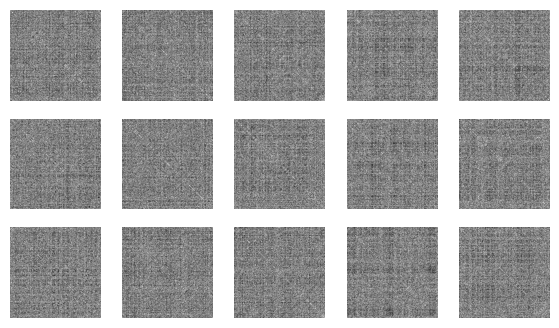

Precomputing variables...


C:\Users\danie\AppData\Local\Temp\ipykernel_21664\2315459437.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  expected_hist_clique.append(torch.tensor(expected_hist_K, dtype=torch.float32))


Completed precomputing variables...
mean diff clique:  tensor([1.4189, 1.4331, 1.4202, 1.4083, 1.4317, 1.4274, 1.4167, 1.4207, 1.4251,
        1.4293, 1.4267, 1.4120, 1.4138, 1.4083, 1.4358])
mean diff no clique:  tensor([1.4182, 1.4474, 1.4383, 1.4320, 1.4680, 1.4441, 1.4293, 1.4228, 1.4335,
        1.4603, 1.4652, 1.4117, 1.3917, 1.3799, 1.4819])
logits:  tensor([-0.0007,  0.0144,  0.0180,  0.0237,  0.0363,  0.0167,  0.0127,  0.0021,
         0.0085,  0.0310,  0.0386, -0.0004, -0.0221, -0.0284,  0.0461])
Soft outputs: tensor([0.4998, 0.5036, 0.5045, 0.5059, 0.5091, 0.5042, 0.5032, 0.5005, 0.5021,
        0.5078, 0.5096, 0.4999, 0.4945, 0.4929, 0.5115])
Hard outputs:  [0 1 1 1 1 1 1 1 1 1 1 0 0 0 1]
Labels:  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Fraction of correct responses:
0.7333333333333333


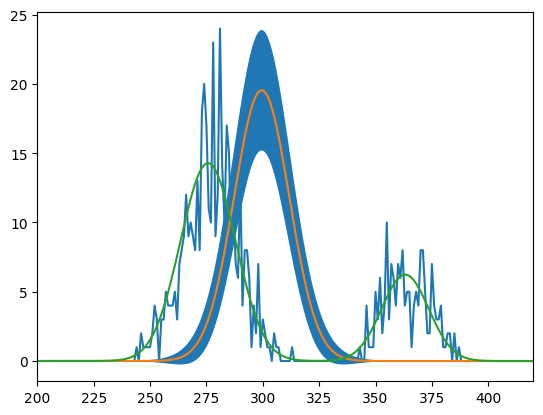

In [72]:
import matplotlib.pyplot as plt

# test of model on task instance
N_value = 600   #CHANGE THIS
clique_size_fraction = 0.27 # CHANGE THIS
print("Clique size of: ", int(clique_size_fraction*N_value), " in a graph of size: ", N_value)
# visualizing input for 15 graphs, "p_reduce"
graphs_with_clique = graphs_gen.generate_batch(15, N_value, np.repeat([int(clique_size_fraction*N_value)],15), "p_reduce", False, p_clique=1)
# Show 15 graphs
fig, axes = plt.subplots(3, 5, figsize=(7, 4))
for i in range(15):
    row = i // 5
    col = i % 5
    axes[row, col].imshow(np.squeeze(graphs_with_clique[0][i]), cmap='gray_r')
    axes[row, col].axis('off')
plt.show()
# testing ideal MLP on this graph:
ideal_MLP = Ideal_MLP(N_value)
soft_output = ideal_MLP(graphs_with_clique[0])
hard_output = (soft_output >= 0.5).long().cpu().numpy()  # threshold at 0.5

print("Soft outputs:", soft_output)
print("Hard outputs: ", hard_output)
print("Labels: ", graphs_with_clique[1])

print("Fraction of correct responses:")
print(np.sum(hard_output == graphs_with_clique[1]) / 15)

# Test function

In [38]:
# read configuration file:
config = load_config(
    os.path.join("Ideal-MLP_test_config.yml")
)  # CHANGE THIS TO PERFORM DIFFERENT EXPERIMENTS

# looping over the different graph sizes in the experiment:
for graph_size in config["graph_size_values"]:
    
    ideal_MLP = Ideal_MLP(graph_size).to(device)

    # Create empty dictionaries for storing testing results:
    fraction_correct_results = {}  # Fraction correct for each clique size
    metrics_results_list = []

    # Calculate max clique size for testing (proportion of graph size):
    max_clique_size_proportion_test = config["testing_parameters"]["max_clique_size_proportion_test"]
    max_clique_size = int(
        max_clique_size_proportion_test * graph_size
    )

    # Calculate array of clique sizes for all test curriculum
    # NOTE: if max clique size is smaller than the the number of test levels, use max clique size as the number of test levels
    clique_sizes = np.linspace(
        max_clique_size,
        1,
        num=min(max_clique_size, config["testing_parameters"]["clique_testing_levels"]),
    ).astype(int)
    
    # Metrics initialization
    TP, FP, TN, FN = 0, 0, 0, 0  
    y_scores = []
    y_true = []    

    # Loop for decreasing clique sizes
    for current_clique_size in clique_sizes:

        # Initialize fraction correct list, updated at each test iteration
        fraction_correct_list = []

        # Loop for testing iterations:
        for test_iter in range(config["testing_parameters"]["test_iterations"]):

            # Generate clique size value of each graph in the current batch
            clique_size_array_test = graphs_gen.generate_batch_clique_sizes(
                np.array([current_clique_size]),
                config["testing_parameters"]["num_test"],
            )

            # Generate validation graphs
            test = graphs_gen.generate_batch(
                config["testing_parameters"]["num_test"],
                graph_size,
                clique_size_array_test,
                config["p_correction_type"],
                False,
            )
            
            # Perform prediction on test data
            soft_output = ideal_MLP(test[0]).squeeze()
            hard_output = (soft_output >= 0.5).int().cpu().numpy()  # converting to hard output (0/1)
            # print(hard_output.shape, test_labels.shape)   # DEBUGGING

            # Update global metrics for AUC-ROC
            y_scores.extend(soft_output.cpu().tolist())
            labels = test[1]
            y_true.extend(list(labels))
             
            # transforming hard_output and test_labels to torch tensors:
            hard_output = torch.tensor(hard_output, dtype=torch.float32)
            test_labels = torch.tensor(test[1], dtype=torch.float32)
            
            # DEBUGGING:
            print("Soft outputs: ", soft_output)
            print("Hard outputs: ", hard_output)
            print("Test labels: ", test_labels)
            
            # Compute metrics
            TP += ((hard_output == 1) & (test_labels == 1)).sum().item()
            FP += ((hard_output == 1) & (test_labels == 0)).sum().item()
            TN += ((hard_output == 0) & (test_labels == 0)).sum().item()
            FN += ((hard_output == 0) & (test_labels == 1)).sum().item()

            # updating fraction correct list with the accuracy of the current test iteration:
            fraction_correct_list.append(
                (hard_output == test_labels).sum().item()
                / (1.0 * config["testing_parameters"]["num_test"])
            )
            
            # delete unused variables
            del test, hard_output, test_labels, clique_size_array_test, soft_output
            torch.cuda.empty_cache()

        # Updating dictionary after all test iterations for current clique size have been completed:
        fraction_correct_results[current_clique_size] = round(
            sum(fraction_correct_list) / len(fraction_correct_list), 2
        )

        # Printing the size of the clique just tested and the corresponding test accuracy:
        print(
            f"||| Completed testing for clique = {current_clique_size}. "
            f"Average fraction correct = {fraction_correct_results[current_clique_size]}"
        )
        print("|||===========================================================")

    # - notify completion of testing:
    print(f"| Finished testing Ideal MLP at N = {graph_size}.")

    # Computing metrics:
    precision = TP / (TP + FP + 1e-10)
    recall = TP / (TP + FN + 1e-10)
    F1 = 2 * (precision * recall) / (precision + recall + 1e-10)
    AUC_ROC = roc_auc_score(y_true, y_scores)
    num_params = sum(
        p.numel() for p in ideal_MLP.parameters()
    )  # storing total number of parameters
    metrics_results = {
        "TP": TP,
        "FP": FP,
        "TN": TN,
        "FN": FN,
        "precision": precision,
        "recall": recall,
        "F1": F1,
        "AUC_ROC": AUC_ROC,
        "total_params": num_params,
    }

    # Saving accuracy results in .csv file:
    # - defining file name and path:
    file_path = os.path.join(
        os.getcwd(), "results", f"Ideal-MLP_N{graph_size}_fraction_correct_1.csv"
    )
    # - saving the dictionary as a .csv file:
    with open(file_path, "w") as file:
        writer = csv.writer(file)
        writer.writerow(["clique size", "fraction correct"])  # Add column labels
        for key, value in fraction_correct_results.items():
            writer.writerow([key, value])
    # Saving metrics results in .csv file:
    # - defining file name and path:
    file_path = os.path.join(
        os.getcwd(), "results", f"Ideal-MLP_N{graph_size}_metrics_1.csv"
    )
    # - saving the dictionary as a .csv file:
    pd.DataFrame([metrics_results]).to_csv(file_path, index=False)

    print(f"- Ideal MLP Results saved successfully for N = {graph_size}.")

Configuration file loaded successfully.
Precomputing variables...
Completed precomputing variables...
mean diff clique:  tensor([1.7938, 1.7900, 1.8115, 1.1287, 1.1151, 1.8122, 1.1212, 1.0994, 1.1367,
        1.2102, 1.1273, 1.1568, 1.7844, 1.1595, 1.7988, 1.1401, 1.7939, 1.2280,
        1.7913, 1.8106, 1.1343, 1.7999, 1.1467, 1.1416, 1.1500, 1.8025, 1.7989,
        1.8001, 1.7932, 1.1600, 1.1111, 1.1013])
mean diff no clique:  tensor([1.9801, 1.9801, 1.9801, 0.3992, 0.3334, 1.9801, 0.3513, 0.2539, 0.3277,
        0.5052, 0.3127, 0.3786, 1.9801, 0.3605, 1.9801, 0.3950, 1.9801, 0.5493,
        1.9801, 1.9801, 0.4298, 1.9801, 0.3388, 0.2928, 0.4561, 1.9801, 1.9801,
        1.9801, 1.9801, 0.3576, 0.3440, 0.3978])
logits:  tensor([ 0.1863,  0.1901,  0.1686, -0.7295, -0.7817,  0.1679, -0.7700, -0.8456,
        -0.8090, -0.7050, -0.8146, -0.7782,  0.1957, -0.7990,  0.1812, -0.7450,
         0.1862, -0.6787,  0.1888,  0.1694, -0.7046,  0.1802, -0.8079, -0.8488,
        -0.6939,  0.1776,  0.1

C:\Users\danie\AppData\Local\Temp\ipykernel_21664\1197703214.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  expected_hist_clique.append(torch.tensor(expected_hist_K, dtype=torch.float32))


tensor([0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 1., 0., 1., 0., 1., 0., 1., 1.,
        1., 0., 1., 0., 1., 1., 0., 1., 1., 1., 0., 1., 1., 0.])
mean diff clique:  tensor([1.6847, 1.6782, 1.6663, 1.1715, 1.1929, 1.1527, 1.6790, 1.1221, 1.1335,
        1.0821, 1.1446, 1.6783, 1.1644, 1.6619, 1.1264, 1.1033, 1.1591, 1.1799,
        1.1584, 1.1252, 1.6628, 1.1482, 1.6640, 1.1143, 1.6602, 1.6695, 1.1366,
        1.1365, 1.1675, 1.1606, 1.2148, 1.1295])
mean diff no clique:  tensor([1.9796, 1.9796, 1.9796, 0.4146, 0.4619, 0.3774, 1.9796, 0.3328, 0.3507,
        0.3143, 0.3888, 1.9796, 0.4394, 1.9796, 0.2616, 0.3303, 0.3731, 0.4135,
        0.4269, 0.3396, 1.9796, 0.3410, 1.9796, 0.3455, 1.9796, 1.9796, 0.3164,
        0.3913, 0.3971, 0.3632, 0.4418, 0.3812])
logits:  tensor([ 0.2949,  0.3014,  0.3134, -0.7570, -0.7310, -0.7753,  0.3007, -0.7893,
        -0.7828, -0.7679, -0.7558,  0.3013, -0.7250,  0.3178, -0.8648, -0.7729,
        -0.7859, -0.7664, -0.7314, -0.7856,  0.3169, -0.8072,  0.31